In [1]:
# project
import os
import sys 
project_dir = os.path.join(os.path.expanduser('~'), 'git', 'diffsim-sysid')
sys.path.insert(1, project_dir)
# math
import numpy as np
import torch
import pytorch3d
import pytorch3d.transforms
# graphics
from copy import deepcopy
import mitsuba as mi
from mitsuba.scalar_rgb import Transform4f as mit
# plots
import matplotlib as mpl
from matplotlib import pyplot as plt
from src.mpl_utils import set_fig_size, set_mpl_format
# config
from src.config import cfg
# dataset
from src.dataset import load_train_data
from src.data.visualize import print_example

# setup
set_mpl_format()
mi.set_variant('llvm_ad_rgb')
print(f'Mitsuba 3 Variant: {mi.variant()}')

2024-04-03 15:57:24.027240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Mitsuba 3 Variant: llvm_ad_rgb


### Config

In [2]:
# fill in your directory set up here
config_fp = os.path.join(project_dir, f'cfg/templates/comp-movi_a.yaml')
cfg.merge_from_file(config_fp)
cfg.DATA.path = os.path.join(project_dir, 'data/sets/')
print(cfg)

DATA:
  fps: 12
  fpv: 24
  height: 256
  max_objs: 10
  path: /home/jonathan/git/diffsim-sysid/data/sets/
  set: movi_a
  width: 256
EVAL:
  OUTPUT:
    FN:
      config: config.yaml
      log: log.txt
      pred: pred.csv
    path: 
  PARAM:
    DENSITY:
      include: True
      prior: 1.35
    FRICTION:
      include: True
      prior: 0.5
    RESTITUTION:
      include: True
      prior: 0.5
SYS_ID:
  GEOM:
    include: True
    spm: 100
  OPTIM:
    beta1: 0.9
    beta2: 0.999
    decay: 0.0
    lr: 0.01
    optim: adam
  VIS:
    include: True
    spp: 4
    weight: 1.0
  iter: 4
  rand: False


### Data

In [3]:
train_ds, ds_info = load_train_data(cfg)
example = next(iter(train_ds))

2024-04-03 15:57:25.944547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 15:57:25.945635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 15:57:25.945863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-03 15:57:25.946241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

In [4]:
time_step = 20
vid_id = example['metadata']['video_name']
obj_count = example['metadata']['num_instances']
print(f'Video: {vid_id}, Num objects: {obj_count}, Timestep: {time_step}')

Video: b'1680', Num objects: 8, Timestep: 20


### Scene

In [5]:
origin = np.array([0, 0, 0])
up = np.array([0, 0, 1])

scene_dict = {
    'type': 'scene'
}

In [6]:
##############
# Integrator #
##############

integrator = 'path'
hide_emitters = True
integrator_dict = {
    'type': integrator,
    'hide_emitters' : hide_emitters
}
scene_dict['integrator'] = integrator_dict

In [7]:
##########
# Camera #
##########

cam_width = int(example['metadata']['width'])
cam_height = int(example['metadata']['height'])

cam_pos = example['camera']['positions'][0]
cam_to_world = mit.look_at(cam_pos, origin, up)

cam_fov = example['camera']['field_of_view'] * 180 / np.pi

cam_rfilter_sttdev = 0.5

cam_dict = {
    'type': 'perspective',
    'to_world': cam_to_world,
    'fov': cam_fov,
    'film': {
        'type': 'hdrfilm',
        'width': cam_width,
        'height': cam_height,
        'rfilter': { 
            'type': 'gaussian',
            'stddev': cam_rfilter_sttdev
            },
        'sample_border': True
    },
}

scene_dict['cam'] = cam_dict

In [8]:
##########
# Ground #
##########

ground_scale = 1000.0
ground_to_world = mit.scale(ground_scale)

ground_rgb = [0.5, 0.5, 0.5]
ground_spec = 0.0
ground_rough = 1.0

ground_dict = {
    'type': 'rectangle',
    'to_world': ground_to_world,
    'bsdf': {
        'type': 'principled',
        'base_color': {
            'type': 'rgb',
            'value': ground_rgb
        },
        'specular': ground_spec,
        'roughness': ground_rough
    }
}
scene_dict['ground'] = ground_dict

In [9]:
##########
# Lights #
##########
lamp_scale = 0.5

sun_light_pos = [11.6608, -6.62799, 25.8232]
sun_light_to_world = mit.look_at(sun_light_pos, origin, up)
sun_light_intensity = 0.45
sun_light_dict = {
        'type': 'directional',
        'to_world': sun_light_to_world,
        'irradiance': {
            'type': 'rgb',
            'value': sun_light_intensity
        }
}
scene_dict['sun'] = sun_light_dict


lamp_back_pos = [-1.1685, 2.64602, 5.81574]
lamp_back_to_world = mit.look_at(lamp_back_pos, origin, up).scale(lamp_scale)
lamp_back_intensity = 50.0 / 3
# lamp_back_dict = {
#     'type': 'rectangle',
#     'to_world': lamp_back_to_world,
#     'emitter' : {
#         'type': 'area',
#         'radiance': {
#             'type': 'rgb',
#             'value': lamp_back_intensity
#         }
#     }
# }
lamp_back_dict = {
        'type': 'point',
        'to_world': lamp_back_to_world,
        'intensity': {
            'type': 'rgb',
            'value': lamp_back_intensity
            }
}
scene_dict['lamp_back'] = lamp_back_dict


lamp_key_pos = np.array([6.44671, -2.90517, 4.2584])
lamp_key_to_world = mit.look_at(lamp_key_pos, origin, up).scale(lamp_scale)
lamp_key_rgb = np.array([255/255.0, 237/255.0, 208/255.0])
lamp_key_intensity = 100.0 / 3
lamp_key_radiance = lamp_key_intensity * lamp_key_rgb
# lamp_key_dict = {
#         'type': 'rectangle',
#         'to_world': lamp_key_to_world,
#         'emitter' : {
#         'type': 'area',
#         'radiance': {
#             'type': 'rgb',
#             'value': lamp_key_radiance
#             } 
#         }
# }
lamp_key_dict = {
        'type': 'point',
        'to_world': lamp_key_to_world,
        'intensity': {
            'type': 'rgb',
            'value': lamp_key_radiance
            }
}
scene_dict['lamp_key'] = lamp_key_dict


lamp_fill_pos = [-4.67112, -4.0136, 3.01122]
lamp_fill_to_world = mit.look_at(lamp_fill_pos, origin, up).scale(lamp_scale)
lamp_fill_rgb = np.array([226/255.0, 233/255.0, 255/255.0])
lamp_fill_intensity = 30.0 / 3
lamp_fill_radiance = lamp_fill_intensity * lamp_fill_rgb
# lamp_fill_dict = {
#         'type': 'rectangle',
#         'to_world': lamp_fill_to_world,
#         'emitter' : {
#         'type': 'area',
#         'radiance': {
#             'type': 'rgb',
#             'value': lamp_fill_radiance
#             } 
#         }
# }
lamp_fill_dict = {
        'type': 'point',
        'to_world': lamp_fill_to_world,
        'intensity': {
            'type': 'rgb',
            'value': lamp_fill_radiance
            }
}
scene_dict['lamp_fill'] = lamp_fill_dict


env_light_intensity = 0.05
env_light_dict = {
        'type': 'constant',
        'radiance': {
            'type': 'rgb',
            'value': env_light_intensity
        }
}
scene_dict['env_light'] = env_light_dict

In [10]:
###########
# Objects #
###########

CLEVR_SHAPE_NAMES = ("cube", "cylinder", "sphere")
CLEVR_SIZE_NAMES = ('small', 'large')
CLEVR_SIZES = (0.7, 1.4)
CLEVR_COLOR_NAMES = ("blue", "brown", "cyan", "gray", "green", "purple", "red", "yellow")
CLEVR_COLORS = ([42/255.0, 75/255.0, 215/255.0], 
              [129/255.0, 74/255.0, 25/255.0], 
              [41/255.0, 208/255.0, 208/255.0], 
              [87/255.0, 87/255.0, 87/255.0], 
              [29/255.0, 105/255.0, 20/255.0], 
              [129/255.0, 38/255.0, 192/255.0], 
              [173/255.0, 35/255.0, 35/255.0], 
              [255/255.0, 238/255.0, 5/255.0])
CLEVR_MATERIAL_NAMES = ("metal", "rubber")


rubber_bsdf_dict = {
    'type': 'principled',
    'base_color': {
        'type': 'rgb'
    },
    'metallic' : 0.0,
    'roughness' : 0.7,
    'eta' : 1.25,
    #'specular' : 0.33
}
metal_bsdf_dict = {
    'type': 'principled',
    'base_color': {
        'type': 'rgb'
    },
    'metallic' : 1.0,
    'roughness' : 0.2,
    'eta' : 2.5
}


for obj_idx in range(obj_count):
    obj_class_idx = example['instances']['shape_label'][obj_idx]
    obj_class = CLEVR_SHAPE_NAMES[obj_class_idx]

    obj_scale_idx = example['instances']['size_label'][obj_idx]
    obj_scale = CLEVR_SIZES[obj_scale_idx] / 2.0
    obj_pos = example['instances']['positions'][obj_idx][time_step]
    obj_rot = example['instances']['quaternions'][obj_idx][time_step]
    obj_aa = pytorch3d.transforms.quaternion_to_axis_angle(torch.tensor(obj_rot)).detach().numpy()
    obj_aa_norm = np.linalg.norm(obj_aa)
    obj_angle = obj_aa_norm * 180 / np.pi
    obj_axis = obj_aa / obj_aa_norm 
    if obj_class == CLEVR_SHAPE_NAMES[1]:
        obj_scale = [obj_scale, obj_scale, 2 * obj_scale]
    obj_to_world = mit.translate(obj_pos).rotate(axis=obj_axis, angle=obj_angle).scale(obj_scale)

    obj_rgb_idx = example['instances']['color_label'][obj_idx]
    obj_rgb = CLEVR_COLORS[obj_rgb_idx]

    obj_material_idx = example['instances']['material_label'][obj_idx]
    obj_material = CLEVR_MATERIAL_NAMES[obj_material_idx]
    if obj_material_idx == 0:
        bsdf_dict = deepcopy(metal_bsdf_dict)
        bsdf_dict['base_color']['value'] = obj_rgb
    elif obj_material_idx == 1:
        bsdf_dict = deepcopy(rubber_bsdf_dict)
        bsdf_dict['base_color']['value'] = obj_rgb

    if obj_class_idx == 1:   
        # cylinders are made of several shapes
        shape_group_name = f'obj_{obj_idx}_group'
        shape_group = {
            'type' : 'shapegroup',
            'body' : {
                'type' : 'cylinder',
                'p0' : np.array([0, 0, -0.5]),
                'p1' : np.array([0, 0, 0.5]),
                'bsdf' : bsdf_dict
            },
            'end1' : {
                'type' : 'disk',
                'to_world' : mit.translate([0, 0, -0.5]),
                'flip_normals' : True,
                'bsdf' : bsdf_dict
            },
            'end2' : {
                'type' : 'disk',
                'to_world' : mit.translate([0, 0, 0.5]),
                'bsdf' : bsdf_dict
            }
        }
        obj_dict = {
            'type': 'instance',
            'to_world': obj_to_world,
            'shapegroup': shape_group
        }
    else:
        obj_dict = {
                'type': obj_class,
                'to_world': obj_to_world,
                'bsdf' : bsdf_dict
            }
    scene_dict[f'obj_{obj_idx}'] = obj_dict

accurate_scene_dict = dict(scene_dict)
accurate_scene_img = mi.render(mi.load_dict(accurate_scene_dict), spp=64)

In [11]:
###########
# Objects #
###########

CLEVR_SHAPE_NAMES = ("cube", "cylinder", "sphere")
CLEVR_SIZE_NAMES = ('small', 'large')
CLEVR_SIZES = (0.7, 1.4)
CLEVR_COLOR_NAMES = ("blue", "brown", "cyan", "gray", "green", "purple", "red", "yellow")
CLEVR_COLORS = ([42/255.0, 75/255.0, 215/255.0], 
              [129/255.0, 74/255.0, 25/255.0], 
              [41/255.0, 208/255.0, 208/255.0], 
              [87/255.0, 87/255.0, 87/255.0], 
              [29/255.0, 105/255.0, 20/255.0], 
              [129/255.0, 38/255.0, 192/255.0], 
              [173/255.0, 35/255.0, 35/255.0], 
              [255/255.0, 238/255.0, 5/255.0])
CLEVR_MATERIAL_NAMES = ("metal", "rubber")


rubber_bsdf_dict = {
    'type': 'principled',
    'base_color': {
        'type': 'rgb'
    },
    'metallic' : 0.0,
    'roughness' : 0.7,
    'eta' : 1.25,
    #'specular' : 0.33
}
metal_bsdf_dict = {
    'type': 'principled',
    'base_color': {
        'type': 'rgb'
    },
    'metallic' : 1.0,
    'roughness' : 0.2,
    'eta' : 2.5
}


for obj_idx in range(obj_count):
    obj_class_idx = example['instances']['shape_label'][obj_idx]
    obj_class = CLEVR_SHAPE_NAMES[obj_class_idx]

    obj_scale_idx = example['instances']['size_label'][obj_idx]
    obj_scale = CLEVR_SIZES[obj_scale_idx] / 2.0
    obj_pos = example['instances']['positions'][obj_idx][time_step]
    obj_rot = example['instances']['quaternions'][obj_idx][time_step]
    obj_aa = pytorch3d.transforms.quaternion_to_axis_angle(torch.tensor(obj_rot)).detach().numpy()
    obj_aa_norm = np.linalg.norm(obj_aa)
    obj_angle = obj_aa_norm * 180 / np.pi
    obj_axis = obj_aa / obj_aa_norm 
    obj_to_world = mit.translate(obj_pos).rotate(axis=obj_axis, angle=obj_angle).scale(obj_scale)

    obj_rgb_idx = example['instances']['color_label'][obj_idx]
    obj_rgb = CLEVR_COLORS[obj_rgb_idx]

    obj_material_idx = example['instances']['material_label'][obj_idx]
    obj_material = CLEVR_MATERIAL_NAMES[obj_material_idx]
    if obj_material_idx == 0:
        bsdf_dict = deepcopy(metal_bsdf_dict)
        bsdf_dict['base_color']['value'] = obj_rgb
    elif obj_material_idx == 1:
        bsdf_dict = deepcopy(rubber_bsdf_dict)
        bsdf_dict['base_color']['value'] = obj_rgb

    obj_dict = {
            'type': 'sphere',
            'to_world': obj_to_world,
            'bsdf' : bsdf_dict
        }
    scene_dict[f'obj_{obj_idx}'] = obj_dict

simple_scene_dict = dict(scene_dict)
simple_scene_img = mi.render(mi.load_dict(simple_scene_dict), spp=64)

### Rendering

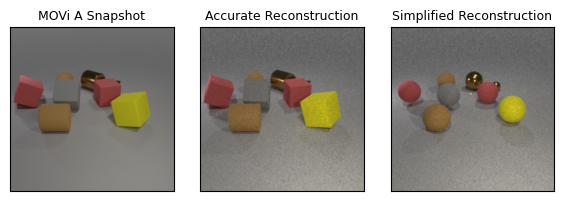

In [15]:
fig_size = set_fig_size(subplots=(1, 3))
fig, axs = plt.subplots(1, 3, figsize=fig_size, constrained_layout=True)


movi_img = example['video'][time_step]
axs[0].imshow(movi_img)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('MOVi A Snapshot')


scene_bitmap = mi.util.convert_to_bitmap(accurate_scene_img)
axs[1].imshow(scene_bitmap)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Accurate Reconstruction')


scene_bitmap = mi.util.convert_to_bitmap(simple_scene_img)
axs[2].imshow(scene_bitmap)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('Simplified Reconstruction')


plt.show()
#plt.savefig('fig_movi_a_mitsuba.pdf', bbox_inches='tight')